# Schneider Electric Hackathon
## Data Science Challenge
### Team 113: Alejandro Argüello, Pablo Bernabeu & Rubén Cuervo


## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastai.vision.all import *
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Create our own test dataset

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/schneider-hackathon/data/train.csv")
train = train_df.sample(frac=0.8, random_state=42)
test = train_df.drop(train.index)

In [ ]:
test.apply(lambda x: shutil.move("/content/drive/My Drive/schneider-hackathon/data/" + x["example_path"],
                                 "/content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial"), axis=1)

1       /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/1199.png
8       /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/2194.png
13      /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/2262.png
14      /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/2280.png
20      /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/1311.png
                                                ...                                         
1687    /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/2308.png
1690      /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/11.png
1694    /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/1248.png
1697     /content/drive/My Drive/schneider-hackathon/data/train_test_data/test_trial/631.png
1710    /content/drive/My Drive/schneider-hackathon/data/train_test_da

In [ ]:
test["example_path"] = test.apply(lambda x: x["example_path"][:16] + "test_trial" + x["example_path"][21:], axis=1)

## Loading the datasets

In [ ]:
path = "/content/drive/My Drive/schneider-hackathon/data/train_test_data/train/"

def get_label(f):
  return train[train["example_path"].str.split("/").str[-1] == f]["label"].reset_index(drop=True).iloc[0]

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=get_label, ds_tfms=RandTransform) # ds_tfms=RandTransform so as to perform DATA AUGMENTATION!

# Data augmentation is key to solve this problem as the data set is scarce (1714 images for training)

## Trial of different commonly employed CNN architectures

### GoogleNet

In [ ]:
learn_google = vision_learner(dls, googlenet, metrics=F1Score(average="macro"))
learn_google.fine_tune(10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,f1_score,time
0,1.576398,0.894941,0.620791,00:15


epoch,train_loss,valid_loss,f1_score,time
0,0.797035,0.849068,0.640155,00:16
1,0.709808,0.926637,0.604823,00:16
2,0.609036,0.951729,0.635386,00:16
3,0.511596,0.932265,0.636787,00:16
4,0.417682,0.946446,0.644901,00:15
5,0.343278,0.951367,0.627797,00:16
6,0.283812,0.996653,0.651060,00:17
7,0.234058,0.983435,0.662015,00:16
8,0.202587,0.986736,0.656528,00:16
9,0.180175,0.992820,0.653960,00:16


### Resnet50

In [ ]:
learn_rn50 = vision_learner(dls, resnet50, metrics=F1Score(average="macro"))
learn_rn50.fine_tune(10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,f1_score,time
0,1.449586,1.392008,0.535135,00:23


epoch,train_loss,valid_loss,f1_score,time
0,0.698496,1.058358,0.583942,00:31
1,0.479462,1.090193,0.656825,00:30
2,0.341169,1.252346,0.663872,00:30
3,0.258219,1.545613,0.660582,00:30
4,0.197130,1.350773,0.688787,00:30
5,0.155320,1.268485,0.702369,00:30
6,0.119708,1.346858,0.684170,00:30
7,0.088566,1.323300,0.682544,00:30
8,0.065221,1.326075,0.675785,00:30
9,0.050189,1.343056,0.675274,00:30


### Efficient Net

In [ ]:
learn_en = vision_learner(dls, efficientnet_b0, metrics=F1Score(average="macro"))
learn_en.fine_tune(10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,f1_score,time
0,1.558315,0.931069,0.638183,00:16


epoch,train_loss,valid_loss,f1_score,time
0,0.837428,0.881236,0.648136,00:17
1,0.755601,0.970555,0.641609,00:18
2,0.672330,1.023242,0.627505,00:18
3,0.594298,1.080250,0.631595,00:17
4,0.532827,1.048057,0.650285,00:18
5,0.454672,0.995069,0.665511,00:19
6,0.390466,1.041924,0.644235,00:18
7,0.351774,0.981924,0.663814,00:17
8,0.319125,0.973502,0.676768,00:18
9,0.281805,0.980309,0.672777,00:17


After trying several of them, we have selected efficient net as the final architecture because it was the one providing the best results.

In [ ]:
learn_en = vision_learner(dls, efficientnet_b0, metrics=F1Score(average="macro"))
learn_en.fine_tune(25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,f1_score,time
0,1.488729,1.137060,0.598512,00:16


epoch,train_loss,valid_loss,f1_score,time
0,0.839011,0.930548,0.609290,00:18
1,0.773994,0.929210,0.639076,00:17
2,0.700421,0.908424,0.626246,00:18
3,0.641530,0.885280,0.667603,00:18
4,0.584259,0.847689,0.687175,00:17
5,0.532588,0.930355,0.646217,00:18
6,0.478758,0.904418,0.688101,00:18
7,0.429569,0.947008,0.704594,00:17
8,0.400339,0.976022,0.659483,00:17
9,0.349856,0.962214,0.689690,00:18


Visualizing the confusion matrix for the best model.

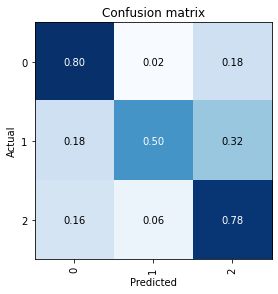

In [ ]:
ClassificationInterpretation.from_learner(learn_en).plot_confusion_matrix(normalize=True)

Obtaining the predictions of the EfficientNet CNN model

In [ ]:
train["predicted_label"] = train.apply(lambda x: int(learn_en.predict("/content/drive/My Drive/schneider-hackathon/data/" + x["example_path"])[0]), axis=1)
test["predicted_label"] = test.apply(lambda x: int(learn_en.predict("/content/drive/My Drive/schneider-hackathon/data/" + x["example_path"])[0]), axis=1)

## XGBoost Model

Introducing the outcome of the CNN to a classifier model (XGBoost) so as to take into account the other features (latitude, longitude and year).

In [ ]:
X_train = train.drop(["label", "example_path"], axis=1)
y_train = train["label"]
X_test = test.drop(["label", "example_path"], axis=1)
y_test = test["label"]

In [ ]:
# We first use scale the input for XGB classifier
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Finiding the best parameters for XGboostusing Grid Search (cross-validated grid-search over a parameter grid).

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5, 6, 7]
        }

xgb_gridsearch = XGBClassifier(random_state=10)
grid = GridSearchCV(xgb_gridsearch, params, refit=True, scoring='f1_macro', cv=5)
xgb_best = grid.fit(X_train, y_train).best_estimator_

In [ ]:
Y_pred_best = xgb_best.predict(X_test)
print(f"F1-Score of the XGB model in training is {round(f1_score(y_train, xgb_best.predict(X_train), average='macro') * 100, 2)}%\n")
print(f"F1-Score of the XGB model in testing is {round(f1_score(y_test, Y_pred_best, average='macro') * 100, 2)}%\n")
print(classification_report(y_test, Y_pred_best))

F1-Score of the XGB model in training is 94.91%

F1-Score of the XGB model in testing is 69.61%

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       170
           1       0.76      0.34      0.47        38
           2       0.73      0.81      0.77       135

    accuracy                           0.78       343
   macro avg       0.78      0.67      0.70       343
weighted avg       0.78      0.78      0.77       343



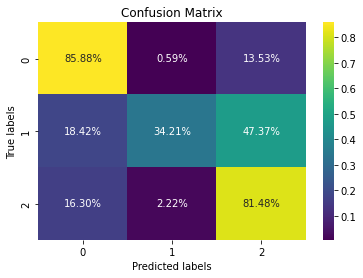

In [ ]:
cm = confusion_matrix(y_test, Y_pred_best, normalize="true")
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="viridis", fmt='.2%')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([0, 1, 2]);
ax.yaxis.set_ticklabels([0, 1, 2])
plt.show()

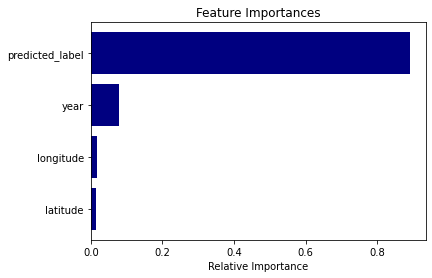

In [ ]:
features = X_train.columns
importances = xgb_best.feature_importances_ # Impurity-based feature importances
indices = np.argsort(importances) # Put feature with biggest importance at the top
plt.title('Feature Importances')
lenn=len(indices)
plt.barh(range(lenn), importances[indices], color='#000080')
plt.yticks(range(lenn), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We can see how the outpout of the CNN is the most important variable for the XGboost to classify the images. Year, latitude and longitude just provide additional classification help.

## Creating the definitive model to predict the test set

We have fitted the model now with the entire training set

In [ ]:
# We move back the images of our own test set to the train folder
test.apply(lambda x: shutil.move("/content/drive/My Drive/schneider-hackathon/data/" + x["example_path"],
                                 "/content/drive/My Drive/schneider-hackathon/data/train_test_data/train"), axis=1)

1       /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/1199.png
8       /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/2194.png
13      /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/2262.png
14      /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/2280.png
20      /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/1311.png
                                             ...                                       
1687    /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/2308.png
1690      /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/11.png
1694    /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/1248.png
1697     /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/631.png
1710    /content/drive/My Drive/schneider-hackathon/data/train_test_data/train/2264.png
Length: 343, dtype: object

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/schneider-hackathon/data/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/schneider-hackathon/data/test.csv")

path = "/content/drive/My Drive/schneider-hackathon/data/train_test_data/train/"

def get_label(f):
  return train_df[train_df["example_path"].str.split("/").str[-1] == f]["label"].reset_index(drop=True).iloc[0]

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=get_label, ds_tfms=RandTransform)

learn_en = vision_learner(dls, efficientnet_b0, metrics=F1Score(average="macro"))
learn_en.fine_tune(25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,f1_score,time
0,1.532526,10.495530,0.349399,00:23


epoch,train_loss,valid_loss,f1_score,time
0,0.960829,4.398138,0.578882,00:29
1,0.836032,0.704143,0.693655,00:22
2,0.753586,0.630910,0.767447,00:23
3,0.675876,0.605871,0.793556,00:23
4,0.611213,0.630846,0.734441,00:23
5,0.561483,0.628427,0.770694,00:23
6,0.501877,0.600592,0.819052,00:25
7,0.456474,0.647752,0.771075,00:23
8,0.409735,0.668388,0.740700,00:23
9,0.366926,0.660557,0.780113,00:22


In [ ]:
train_df["predicted_label"] = train_df.apply(lambda x: int(learn_en.predict("/content/drive/My Drive/schneider-hackathon/data/" + x["example_path"])[0]), axis=1)
test_df["predicted_label"] = test_df.apply(lambda x: int(learn_en.predict("/content/drive/My Drive/schneider-hackathon/data/" + x["example_path"])[0]), axis=1)

In [ ]:
X_train = StandardScaler().fit_transform(train_df.drop(["label", "example_path"], axis=1))
y_train = train_df["label"]

In [ ]:
# Takes the best parameters from the previous grid search
xgb_final_classifier = grid.best_estimator_
xgb_final_classifier.fit(train_df.drop(["label", "example_path"], axis=1), train_df["label"])

XGBClassifier(gamma=1, max_depth=4, objective='multi:softprob', random_state=10)

In [ ]:
predictions = pd.DataFrame(xgb_final_classifier.predict(test_df.drop(["example_path"], axis=1)))
predictions.to_json("/content/drive/My Drive/schneider-hackathon/predictions.json") # Converting the predicitons to the desired format (json)